In [1]:
import pandas as pd
import numpy as np
import re
import os
from scipy.signal import find_peaks
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.lines import Line2D
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.stats import ttest_ind
from scipy.stats import levene
from scipy.optimize import curve_fit

In [2]:
# names of the experiments for naming of the files
experiment_list = ["E007", "E008", "E011"]

# list of the names of the excel files with the raw data of the experiments
file_name_list = ["..\\data\\" + i for i in os.listdir("..\\data") if i.endswith(".xlsx")]
file_name_list

['..\\data\\39_20230710_Kai_mutants.xlsx',
 '..\\data\\40_20230717_Kai_mutants_and_friends.xlsx',
 '..\\data\\43_20230731_Kai_mutants_and_friends.xlsx']

In [3]:
# conversion factor from inches to cm for the size of the plots
cm_in_inches = 2.54
width = 21 * 2
height = 27.6 * 2
dimensions1 = (height/cm_in_inches, width/cm_in_inches)
dimensions2 = (width/cm_in_inches, height/2/cm_in_inches)
lw = 2

In [4]:
# dictionary with the colors associated with the strains contained in the experiments
color_dic = {r"WT": "forestgreen",
             r"KaiA3": "brown",
             r"KaiB3": "crimson",
             r"KaiC3": "darkorange",
             r"KaiA3B3": "olive",
             r"KaiA3C3": "lawngreen",
             r"KaiB3C3": "mediumturquoise",
             r"KaiA3B3C3": "dodgerblue",
             r"KaiA1B1C1": "orchid"}

In [5]:
def renaming_of_raw_data(file_name_list:list, experiments:list, save=False) -> None:

    """
    This function reads in the raw data as a pandas DataFrame and renames the
    columns based on the names given to each well in the BioLection software.
    The data is then trimmed to the first 84 h and unnecessary strains are removed
    and the result is saved to a csv file.
    """

    for file, experiment in zip(file_name_list, experiments):
        # raw data is saved in sheet 4 of the excel file
        raw_data = pd.read_excel(file, sheet_name=3, skiprows=range(1,4))
        keys = raw_data.keys()[2:]
        keys_dict = {i: re.sub(r"Ch\d_", r"", j) for i, j in zip(keys, keys)}
        raw_data = raw_data.rename(columns=keys_dict)
        raw_data = raw_data[[i for i in raw_data.keys() if i.startswith("raw") or i.startswith("Time[h]")]]


        my_names = [i.replace("raw_", "") for i in raw_data.keys()]
        # the names are saved in sheet 2 of the excel file
        names = pd.read_excel(file, sheet_name=1, skiprows=range(1,4))
        names = names.query("Well == @my_names")
        names_dict = {"raw_" + i: j.replace(",", "").replace(" ", "_").replace("Uppsala_", "") for i, j in zip(names["Well"], names["Description"])}
        raw_data = raw_data.rename(columns=names_dict)

        # trimming the data to the first 84 h
        index_end = raw_data[raw_data["Time[h]"] <= 84].shape[0] + 1 
        raw_data = raw_data.iloc[:index_end,]   

        # trimming strains that are not needed:
        raw_data = raw_data[[key for key in raw_data.keys() if not re.search(r"7942|mVenus|glgC", key)]] #|Wilde

        # saving the result to a csv file:
        if save:
            raw_data.to_csv(f"..\\data\\{experiment}_renamed_data.csv")

In [6]:
renaming_of_raw_data(file_name_list, experiment_list, save=True)

In [7]:
def identify_unique_keys(experiment_list:list) -> dict:

    """
    Function for identifying the unique part of the names of the DataFrame
    and saving them in a dictionary sorted by the experiments.
    """

    experiments_2_key_2_names = {}
    for experiment in experiment_list:
        data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
        unique_keys = {}
        for i in data.keys()[1:]:
            unique_part = "_".join(i.split("_")[0:2])
            if unique_part not in unique_keys:
                unique_keys[unique_part] = []
            unique_keys[unique_part].append(i)

        experiments_2_key_2_names[experiment] = unique_keys
    return experiments_2_key_2_names

In [8]:
experiment_keys = identify_unique_keys(experiment_list=experiment_list)

In [9]:
def polynomial_regression(y:pd.Series, kernel:np.ndarray, poly=4) -> tuple[np.ndarray, np.ndarray, np.ndarray]:

    """
    Take a pd.Series from the raw data and fit a polynomial regression of the 4th degree to it.
    The smoothed signal, signal and polynomial regression are returned. Function adapted from
    Berwanger et al. 2023 (https://doi.org/10.1101/2023.09.26.559469).
    """
    # 4th degree polynomial regression
    y_reg = np.array(np.arange(len(y))).reshape(-1,1)
    pf = PolynomialFeatures(poly)
    y_reg = pf.fit_transform(y_reg)
    reg_fit = LinearRegression().fit(y_reg, y)
    reg_predict = reg_fit.predict(y_reg)

    # the polynomial regression is subtracted from the raw data
    signal = y - reg_predict
    # from the result, the mean is subtracted
    signal -= signal.mean()
    #the signal is smoothened by a rolling average with the kernel size given to the function
    smoothed_signal = np.convolve(signal, kernel, mode='same')
    return smoothed_signal, signal, reg_predict

In [10]:
def avg_first_data(experiment_list:list, experiment_keys:dict) -> None:

    """
    Function for calculating the average of all replicates of one experiment
    and performing the regression analysis on it afterwards.
    The results are saved to a csv file.
    """

    for experiment in experiment_list:

        # reading in the trimmed and renamed data
        raw_data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
        unique_keys = experiment_keys[experiment]

        data = pd.DataFrame()

        data["Time(h)"] = raw_data["Time[h]"]

        kernel_size = 40
        kernel = np.ones(kernel_size) / kernel_size

        # the first three hours are cut off to eliminate measuring artifacts
        index_1 = data["Time(h)"][data["Time(h)"] >= 3].index[0]

        for key in unique_keys:
            keys = unique_keys[key]
            sub_data = raw_data[keys]

            for i in sub_data.keys():
                data[i] = sub_data[i]

            mean = np.mean(sub_data, axis=1)
            std = np.std(sub_data, axis=1)

            mean_name = key + "_mean"
            sd_name = key + "_sd"
            reg_name = key + "_reg"
            sig_name = key + "_signal"
            smooth_name = key + "_smoothed"

            data[mean_name] = mean
            data[sd_name] = std

            # regression analysis
            smoothed_signal, signal, reg_predict = polynomial_regression(data[mean_name][index_1:], kernel)

            smoothed_signal[smoothed_signal.shape[0] - kernel_size:] = np.nan
            smoothed_signal[:kernel_size] = np.nan

            nan_arr = np.array([np.nan for i in range(0, data.shape[0] - smoothed_signal.shape[0])])
            smoothed_signal = pd.DataFrame(np.concatenate([nan_arr, smoothed_signal], axis=0), columns=[smooth_name])
            signal = pd.DataFrame(np.concatenate([nan_arr, signal], axis=0), columns=[sig_name])
            reg_predict = pd.DataFrame(np.concatenate([nan_arr, reg_predict], axis=0), columns=[reg_name])

            data = pd.concat([data, reg_predict, signal, smoothed_signal], axis=1, ignore_index=False)
        data.to_csv(f"..\\data\\{experiment}_total_data_mean_first.csv")

In [11]:
avg_first_data(experiment_list, experiment_keys)

In [12]:
def avg_last_data(experiment_list:list, experiment_keys_keys:dict) -> None:

    """
    Function for performing the regression analysis for each replicate first
    and then taking the average of the resulting smoothed signal.
    The results are saved to a csv file.
    """

    for experiment in experiment_list:
        
        # reading in the trimmed data set
        raw_data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
        unique_keys = experiment_keys[experiment]

        data = pd.DataFrame()

        data["Time(h)"] = raw_data["Time[h]"]

        kernel_size = 40
        kernel = np.ones(kernel_size) / kernel_size
        
        # the first three hours are cut off to eliminate measuring artifacts
        index_1 = data["Time(h)"][data["Time(h)"] >= 3].index[0]

        cutoff = data.shape[0] - data[index_1:].shape[0]

        for key in unique_keys:
            keys = unique_keys[key]
            sub_data = raw_data[keys]

            for i in sub_data.keys():
                data[i] = sub_data[i]

                reg_name = i + "_reg"
                sig_name = i + "_signal"
                smooth_name = i + "_smoothed"

                smoothed_signal, signal, reg_predict = polynomial_regression(data[i][index_1:], kernel)

                smoothed_signal[smoothed_signal.shape[0] - kernel_size:] = np.nan
                smoothed_signal[:kernel_size] = np.nan

                nan_arr = np.array([np.nan for i in range(0, cutoff)])
                smoothed_signal = pd.DataFrame(np.concatenate([nan_arr, smoothed_signal], axis=0), columns=[smooth_name])
                signal = pd.DataFrame(np.concatenate([nan_arr, signal], axis=0), columns=[sig_name])
                reg_predict = pd.DataFrame(np.concatenate([nan_arr, reg_predict], axis=0), columns=[reg_name])
                data = pd.concat([data, reg_predict, signal, smoothed_signal], axis=1, ignore_index=False)

            smoothed_data = data[[j for j in data.keys() if re.search(r"smoothed", j) and re.search(key + "_", j)]][cutoff:]

            mean_name = key + "_mean"
            sd_name = key + "_sd"

            mean = np.mean(smoothed_data, axis=1)
            std = np.std(smoothed_data, axis=1)

            mean = pd.DataFrame(np.concatenate([nan_arr, mean], axis=0), columns=[mean_name])
            std = pd.DataFrame(np.concatenate([nan_arr, std], axis=0), columns=[sd_name])

            data[mean_name] = mean
            data[sd_name] = std

        data.to_csv(f"..\\data\\{experiment}_total_data_mean_after.csv")

In [13]:
avg_last_data(experiment_list, experiment_keys)

In [14]:
def peak_timepoint_csv(experiment_list:list) -> None:

    """
    Function for identifying the peaks in the smoothed signal.
    The timepoints and heights of the peaks for each strain are saved to a csv file.
    """

    for experiment in experiment_list:
        data = pd.read_csv(f"..\\data\\{experiment}_total_data_mean_after.csv", index_col=0)
        sub_data = data[[key for key in data.keys() if re.search(r"rep\d_smoothed|Time", key)]]
        peaks_df = pd.DataFrame()
        for key in sub_data.iloc[:,1:]:
            mean = np.mean(sub_data[key])
            maximum = np.max(sub_data[key])

            # identifying of the peaks:
            #peaks need to be separated by 150 indices, have a width of at least 65 indices and a height of at least the mean + 20 % of the highest value
            peaks = find_peaks(sub_data[key], distance=150, width=65, height=mean+0.2*maximum) # 150 <=> 12.5 h; 65 <=> 5.42 h
            peaks = peaks[0]
            peak_timepoints = np.array([])
            peak_heights = np.array([])
            name = "{}_{}_{}".format(key.split("_")[0], key.split("_")[1], key.split("_")[2])
            for peak in peaks:
                # only peaks after 12 h are considered
                if sub_data["Time(h)"][peak] >= 12:
                    peak_timepoints = np.append(peak_timepoints, np.array(sub_data["Time(h)"][peak]))
                    peak_heights = np.append(peak_heights, np.array(sub_data[key][peak]))
                else:
                    continue
            # arrays with less than 3 peak timepoints/heights are filled with np.nan so that the results can be put into a DataFrame            
            if peak_timepoints.shape[0] < 3:
                for i in range(0, 3 - peak_timepoints.shape[0]):
                    peak_timepoints = np.append(peak_timepoints, np.nan)
                    peak_heights = np.append(peak_heights, np.nan)
            peaks_df[name + "_peak_timepoints_(h)"] = peak_timepoints
            peaks_df[name + "_peak_heights_(a.u.)"] = peak_heights
        peaks_df.to_csv(f"..\\data\\{experiment}_peaks_and_timepoints.csv")

In [15]:
peak_timepoint_csv(experiment_list)

In [16]:
def peaks_stats_single_experiment(experiment_list:list, experiment_keys:dict) -> None:

    """
    Function to perform normalization of the peak data to make them comparable between experiments.
    The ratio of the height and the phase shift of the first peak compared to the WT are calculated.
    The results are stored in a DataFrame and saved to a csv file.
    """
    for experiment in experiment_list:
        # reading in the data for peak height and timepoints
        peaks_df = pd.read_csv(f"..\\data\\{experiment}_peaks_and_timepoints.csv", index_col=0)
        unique_keys = experiment_keys[experiment]

        # DataFrame to store the calculated values in
        mean_peaks = pd.DataFrame()

        for key in unique_keys:
            # sorting for the individual strains
            sub_data = peaks_df[[i for i in peaks_df.keys() if re.search(key + r"_", i)]]

            # only the timepoints
            timepoints = sub_data[[i for i in sub_data.keys() if re.search(r"timepoints", i)]]

            # number of replicates
            n = len(timepoints.iloc[0,:])

            # calculating the mean timepoint for only the first peak
            mean_tp = np.mean(timepoints.iloc[0,:])
            # calculating the standard deviation of the timepoint of the first peak
            sd_tp = np.std(timepoints.iloc[0,:])

            # only the heights of the peaks
            heights = sub_data[[i for i in sub_data.keys() if re.search(r"heights", i)]]

            # calculating the mean height for only the first peak
            mean_h = np.mean(heights.iloc[0,:])
            # calculating the standard deviation of the height of the first peak
            sd_h = np.std(heights.iloc[0,:])

            # storing the values of the WT in variables for comparison
            if re.search(r"6803_WT", key):
                WT_mean_tp = mean_tp
                WT_sd_tp = sd_tp
                WT_mean_h = mean_h
                WT_sd_h = sd_h
            
            # height ratio of each strain compared to the WT
            h_ratio = mean_h / WT_mean_h
            # error for the height ratio
            ratio_error = sd_h / mean_h  + WT_sd_h / WT_mean_h
            # difference in timpoint of the first peak of each strain compared to the WT (phase shift)
            tp_difference = mean_tp - WT_mean_tp
            # error of the phase shift
            difference_error = sd_tp + WT_sd_tp

            value_list = [mean_tp, sd_tp, mean_h, sd_h, tp_difference, difference_error, h_ratio, ratio_error]

            # adding each value to a DataFrame
            mean_peaks[key + f"_n={n}"] = value_list

        # renaming the rows of the DataFrame
        mean_peaks = mean_peaks.rename(index={0: "mean_timepoint",
                        1: "sd_timepoint",
                        2: "mean_height",
                        3: "sd_height",
                        4: "difference_timepoint_to_WT",
                        5: "difference_error",
                        6: "ratio_height_to_WT",
                        7: "ratio_error"})
                        
        # saving to csv
        mean_peaks.to_csv(f"..\\data\\{experiment}_peak_stats.csv")

In [17]:
peaks_stats_single_experiment(experiment_list, experiment_keys)

In [18]:
def renamed_data_to_separate_csvs(filepath:str, kernel_size:int) -> None:

    """ Function to read out the renamed raw data and perform the regression analysis to save the results into separate csv files"""

    # kernel for the smoothing of the signal
    kernel = np.ones(kernel_size) / kernel_size
    

    # data read in
    data = pd.read_csv(filepath, index_col=0)

    # determine from the filepath which experiment it is
    experiment = re.findall(r"E\d\d\d", filepath)[0]

    # empty DataFrames for storage of the results
    smooth_df = pd.DataFrame()
    sig_df = pd.DataFrame()
    reg_df = pd.DataFrame()

    # only data from 3 h onwards are considered
    index_1 = data["Time[h]"][data["Time[h]"] >= 3].index[0]
    data = data[index_1:]

    # inserting the Time [h] column into each DataFrame,
    # for the smoothed data the kernel size is cut of from both ends because the results at the ends are not reliable
    smooth_df[data.keys()[0]] = data[data.keys()[0]][kernel_size:len(data[data.keys()[0]])-kernel_size]
    sig_df[data.keys()[0]] = data[data.keys()[0]]
    reg_df[data.keys()[0]] = data[data.keys()[0]]

    # loop through the data (excluding the time),
    # performing the regression analysis and 
    # storing the results in the separate DataFrames
    for column in data.keys()[1:]:
        smooth, sig, reg = polynomial_regression(data[column], kernel)
        smooth_df[column] = smooth[kernel_size:len(smooth)-kernel_size]
        sig_df[column] = sig
        reg_df[column] = reg

    # reindexing of the DataFrames
    smooth_df = smooth_df.reindex(index=pd.Index(range(data.shape[0]+index_1)))
    sig_df = sig_df.reindex(index=pd.Index(range(data.shape[0]+index_1)))
    reg_df = reg_df.reindex(index=pd.Index(range(data.shape[0]+index_1)))

    # saving the DataFrames into separate csv files
    smooth_df.to_csv(f"..\\data\\{experiment}_smoothed_data.csv")
    sig_df.to_csv(f"..\\data\\{experiment}_signal_data.csv")
    reg_df.to_csv(f"..\\data\\{experiment}_polynomial_regression_data.csv")

In [19]:
files = ["..\\data\\E007_renamed_data.csv",
         "..\\data\\E008_renamed_data.csv",
         "..\\data\\E011_renamed_data.csv"]
for file in files:
        renamed_data_to_separate_csvs(filepath=file, kernel_size=50)

In [20]:
def calculate_first_period(search_key:str, files:list) -> pd.DataFrame:

    """ Function to calculate the time difference between the first trough and first peak and 
    multiply by two to determine an estimate for the (initial) period of the (damped) oscillation.
    (parial) results are saved as csv files. Which strain is analyzed is determined by the search key."""

    # extracting the experiment names from the list of file names for naming of the output files
    experiments = [re.findall(r"E\d\d\d", string)[0] for string in files]

    # loading the data from files
    smoothed = [pd.read_csv(file, index_col=0) for file in files]

    # empty DataFrame for the results
    experiment_df = pd.DataFrame()
    
    for i in range(len(smoothed)):

        if len([key for key in smoothed[i].keys() if re.search(search_key, key)]) > 0:

            experiment = experiments[i]
            experiment_df[f"{experiment}_Time[h]"] = smoothed[i]["Time[h]"]

            # depending on the experiment, some replicates are discarded due to technical artifacts in the data
            if experiment == "E007":
                for key in sorted([key for key in smoothed[i].keys() if re.search(search_key, key)
                                   and not re.search(r"Wilde", key)]):
                    experiment_df[experiment + "_" + key] = smoothed[i][key]
            elif experiment == "E008":
                for key in sorted([key for key in smoothed[i].keys() if re.search(search_key, key)
                                and not re.search(r"Wilde", key)]):
                    experiment_df[experiment + "_" + key] = smoothed[i][key]
            elif experiment == "E011":
                for key in sorted([key for key in smoothed[i].keys() if re.search(search_key, key)
                                and not re.search(r"Wilde", key)]):
                    experiment_df[experiment + "_" + key] = smoothed[i][key]

    # data from all experiments are concatenated into one file               
    experiment_df.to_csv(f"..\\data\\{search_key}_all_experiments_smoothed_data.csv")

    # empty DataFrames for the first peaks and troghs
    peaks_df = pd.DataFrame()
    troughs_df = pd.DataFrame()

    # peaks and troughs of the strain are determined for each experiment in the DataFrame
    for exp in experiments:
        for key in [key for key in experiment_df.keys() if re.search(exp, key) and not re.search(r"Time", key)]:

            time = experiment_df[f"{exp}_Time[h]"]

            # peaks have to be at least 150 measurements (~12.5 h) apart and have a width of 50 measurements (~4.2 h)
            peaks = find_peaks(experiment_df[key], distance=150, width=50)
            troughs = find_peaks(experiment_df[key]*-1, distance=150, width=50)

            # only for the first peak/trough
            peaks_t = np.array(time.iloc[peaks[0]])[0]
            troughs_t = np.array(time.iloc[troughs[0]])[0]

            # first peak/trough are added to the DataFrames
            peaks_df.loc[0, key] = peaks_t
            troughs_df.loc[0, key] = troughs_t

    # DataFrames are saved as csv files
    peaks_df.to_csv(f"..\\data\\{search_key}_all_experiments_peaks.csv")
    troughs_df.to_csv(f"..\\data\\{search_key}_all_experiments_troughs.csv")


    # empty DataFrame for the first period
    first_period_df = pd.DataFrame()

    # first period is calculated by subtracting the time of the first trough from the time of
    # the first peak and dividing the result by 2
    # the result is added to the DataFrame
    for key in peaks_df.keys():
        first_period_df[key] = np.abs((peaks_df[key] - troughs_df[key]) * 2)

    # the DataFrame is saved to a new csv file
    first_period_df.to_csv(f"..\\data\\{search_key}_all_experiments_first_period.csv")

In [21]:
smoothed_files = ["..\\data\\E007_smoothed_data.csv",
                "..\\data\\E008_smoothed_data.csv",
                "..\\data\\E011_smoothed_data.csv"]
search_keys = ["WT", "A3B3C3", "KaiC3", "KaiA3_", "KaiA3B3_", "KaiA3C3", "KaiB3C3"]
for key in search_keys:
    calculate_first_period(search_key=key, files=smoothed_files)

In [22]:
def sort_avg_sd(data:pd.DataFrame, sort_key:str) -> tuple[pd.Series, pd.Series]:
    filtered = data[sorted([key for key in data.keys() if re.search(sort_key, key) and not re.search(r"Wilde", key)])]
    avg = np.mean(filtered, axis=1)
    sd = np.std(filtered, axis=1, ddof=1)
    return avg, sd

In [23]:
def multiplot_4x3(color_dic:dict, dimensions:tuple, lw:int=1.5) -> None:

    """
    Function for plotting the data from the first experiment and the normalized data from all three experiments to a
    4x2 subplot.
    """

    def set_axis(ax:plt.Axes, xlim:tuple, ylim:tuple, xticks_major:list, xticks_minor:list,
                 yticks_major:list, yticks_minor:list, xlabel:str, ylabel:str) -> None:
        """
        Function for formating the x- and y-axes.
        """
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)

        ax.set_xticks(xticks_major)
        ax.set_xticklabels(xticks_major)
        ax.set_xticks(xticks_minor, minor=True)
        ax.set_xticklabels(xticks_minor, minor=True)

        ax.set_yticks(yticks_major)
        ax.set_yticklabels(yticks_major)
        ax.set_yticks(yticks_minor, minor=True)
        # ax.set_yticklabels(yticks_minor, minor=True)

        ax.tick_params(axis="both", which="major", labelsize=14, length=5)
        ax.tick_params(axis="both", which="minor", labelsize=12, length=3)

        if xlabel == "off":
            ax.set_xticklabels([])
            ax.set_xticklabels([], minor=True)
        else:
            ax.set_xlabel(xlabel, fontsize=16)

        if ylabel == "off":
            ax.set_yticklabels([])
            ax.set_yticklabels([], minor=True)
        else:
            ax.set_ylabel(ylabel, fontsize=16)
        

        return
    
    
    ##############################################################################################
    def plot_growth_with_sd(data:pd.DataFrame, ax:plt.Axes, search_key:str, xlabel:bool=False, ylabel:bool=False) -> None:

        """
        Function for plotting the raw signal from the BioLector with standard deviation and a regression curve 
        for reference. Which axis to plot to and which strain to plot can be specified with the ax and search_key argument.
        """

        sub_data = data[[i for i in data.keys() if re.search(search_key, i)]]

        x = data["Time(h)"]
        y1 = sub_data[f"{search_key}_mean"]
        sd1 = sub_data[f"{search_key}_sd"]
        y2 = sub_data[f"{search_key}_reg"]

        for key in color_dic:
            if re.search(key, search_key):
                color = color_dic[key]

        name = search_key.removeprefix("6803_").removesuffix("_mean").replace("delta", "\u0394").replace("_", " ").replace("K", "k")

        n = data[[i for i in data.keys() if re.search(search_key + r"_rep\d", i)]].shape[1]

        ax.plot(x, y1, color=color, lw=lw, label=f"{name} \u00B1 sd; n = {n}")
        ax.fill_between(x, y1+sd1, y1-sd1, color=color, alpha=0.4)
        ax.plot(x, y2, color="k", alpha=1, lw=1.5, ls="--", label="Polynomial Regression")

    #########################################################################################

    #########################################################################################    
    def plot_signal_with_sd(data:pd.DataFrame, ax:plt.Axes, search_key:str, experiment:str) -> None:

        """
        Function for plotting the isolated and smoothed oscillation signal with standard deviation
        agains the time. Which axis to plot to and which strains to plot can be specified with the ax and search_key argument.
        """
        sub_data = data[[i for i in data.keys() if re.search(search_key, i)
                        and (re.search(r"mean", i)
                        or re.search(r"sd", i))]]


        x = data["Time(h)"]


        for key in sorted([j.removesuffix("_mean") for j in sub_data.keys() if j.endswith("_mean")]):
            y = sub_data[key + "_mean"]
            sd = sub_data[key + "_sd"]

            for key2 in color_dic:
                if re.search(key2, key):
                    color = color_dic[key2]
        
            n = len(experiment_keys[experiment][key])
            
            name = key.removeprefix("6803_").removesuffix("_smoothed").replace("delta", "\u0394").replace("d", "\u0394").replace("K", "k")
            ax.fill_between(x, y-sd, y+sd, color=color, alpha=0.4)
            ax.plot(x, y,color=color, lw=1.5, label=f"{name} \u00B1 sd\nn = {n}")


    #########################################################################################
        
    #########################################################################################
    def first_period_boxplot(ax:plt.Axes) -> None:

        """
        Function to make a boxplot for the first periods from all replicates of the WT, dkaiA1B1C, dkaiA3B3C3 and 
        dkaiC3 strains.
        """

        # loading the data from csv files
        WT = pd.read_csv("..\\data\\WT_all_experiments_first_period.csv", index_col=0).iloc[0,:]
        A3B3C3 = pd.read_csv("..\\data\\A3B3C3_all_experiments_first_period.csv", index_col=0).iloc[0,:]
        C3 = pd.read_csv("..\\data\\KaiC3_all_experiments_first_period.csv", index_col=0).iloc[0,:]
        A3 = pd.read_csv("..\\data\\KaiA3__all_experiments_first_period.csv", index_col=0).iloc[0,:]
        A3B3 = pd.read_csv("..\\data\\KaiA3B3__all_experiments_first_period.csv", index_col=0).iloc[0,:]
        A3C3 = pd.read_csv("..\\data\\KaiA3C3_all_experiments_first_period.csv", index_col=0).iloc[0,:]
        B3C3 = pd.read_csv("..\\data\\KaiB3C3_all_experiments_first_period.csv", index_col=0).iloc[0,:]

        boxplot_list = [WT, A3B3C3, C3, A3, A3B3, A3C3, B3C3]
        color_List = ["forestgreen", "dodgerblue", "darkorange", "brown", "olive", "lawngreen", "mediumturquoise"]


        def make_boxplot(data:pd.Series, ax:plt.Axes, pos:int) -> None:        
            
            ax.boxplot(x=data, positions=[pos], showfliers=False, widths=[0.4], medianprops={"color": "firebrick", "lw": 1.5, "zorder": 1},
                    showmeans=True, meanline=True, meanprops={"color": "navy", "ls": "--", "lw": 1.5})
            return
        
        def make_scatterplot(data:pd.Series, ax:plt.Axes, color:str, pos:int, marker:str) -> str:
            name = data.keys()[0].split("_")[2]
            ax.scatter(x=np.repeat(pos, len(data)), y=data, color=color, label=f"{name}; n={len(data)}", s=40, marker=marker, edgecolors="k", lw=0.5)
            return name
        
        names = []
        for i, strain in enumerate(boxplot_list):
            color = color_List[i]
            make_boxplot(strain, ax, pos=i)

            exp1 = strain[[key for key in strain.keys() if re.search(r"E007", key)]]
            name = make_scatterplot(exp1, ax, color=color, pos=i-0.1, marker="o")

            exp2 = strain[[key for key in strain.keys() if re.search(r"E008", key)]]
            name = make_scatterplot(exp2, ax, color=color, pos=i, marker="^")

            if not re.search(r"A3B3C3", strain.keys()[0]):
                exp3 = strain[[key for key in strain.keys() if re.search(r"E011", key)]]
                name = make_scatterplot(exp3, ax, color=color, pos=i+0.1, marker="s")

            names.append(name) 

        names = [name.replace("delta", "\u0394") for name in names]


        ax.set_ylim(18, 30)
        ax.set_yticks(range(18, 31, 4), minor=False)
        ax.set_yticks(range(18, 31, 2), minor=True)
        ax.set_ylabel("$1^{st}$ Period [h]", fontsize=16)

        lengths = [df.shape[0] for df in boxplot_list]
        labels = []

        for label, length in zip(names, lengths):
            labels.append(f"{label}\nn={length}")


        ax.tick_params(axis="both", which="major", length=5, labelsize=14)
        ax.tick_params(axis="both", which="minor", length=3)

        ax.set_xticklabels(labels, fontsize=16, rotation=0, horizontalalignment="center")


    ###############################################################################################

    ###############################################################################################
    def smoothed_and_fit(ax:plt.Axes, data:pd.DataFrame, data_average:pd.Series, data_sd:pd.Series,
                        color:str, name:str, period:tuple, phi:tuple) -> None:
        """
        Function for plotting the smoothed oscillation signal and a cosine fit to the axis given.
        """

        def cos_func(x, A, omega, phi):
            return A*np.cos(omega*x+phi)


        def fit_cos(ax:plt.Axes, data:pd.DataFrame, data_average:pd.Series,
                    period_l:int, period_u:int, phi_l:int, phi_u:int) -> None:

            A = (max(data_average.dropna()) - np.mean(data_average.dropna()))
            omega_l = 2*np.pi/period_l
            omega_u = 2*np.pi/period_u

            popt, pcov = curve_fit(f=cos_func, xdata=data["Time[h]"].dropna(), ydata=data_average.dropna(),
                                bounds=([0, omega_u, phi_l], [A, omega_l, phi_u]))

            calc_period = 1/popt[1]*2*np.pi

            ax.plot(data["Time[h]"], cos_func(data["Time[h]"], popt[0], popt[1], popt[2]), c="k", ls=":", label="fit", lw=1.5)

            return
    
        period_l = period[0]
        period_u = period[1]

        phi_l = (2*np.pi)/phi[1]
        phi_u = (2*np.pi)/phi[0]
        
        ax.plot(data["Time[h]"], data_average, color=color, label=f"{name} \u00B1 sd", lw=1.5)
        ax.fill_between(data["Time[h]"], data_average+data_sd, data_average-data_sd, color=color, alpha=0.3)

        fit_cos(ax, data, data_average, period_l, period_u, phi_l, phi_u)


        ax.set_yticks(range(-6, 7, 2), minor=False)
        ax.set_yticks(range(-7, 8, 1), minor=True)

        ax.set_xticks(range(0, 84, 24), minor=False)
        ax.set_xticks(range(0, 84, 12), minor=True)

        ax.set_xticklabels(list(range(0, 84, 12)), minor=True)


        return
#############################################################################################################
        
    # data of the first experiment with the mean and std beeing taken after the regression analysis
    E007_data_avg_last = pd.read_csv("..\\data\\E007_total_data_mean_after.csv", index_col=0)
    # data of the first experiment with mean and std beeing taken befor the regression analysis
    E007_data_avg_first = pd.read_csv("..\\data\\E007_total_data_mean_first.csv", index_col=0)

    # data of the 1st peak phase shift and relative amplitude of all three experiments
    E007 = pd.read_csv("..\\data\\E007_peak_stats.csv", index_col=0)
    E008 = pd.read_csv("..\\data\\E008_peak_stats.csv", index_col=0)
    E011 = pd.read_csv("..\\data\\E011_peak_stats.csv", index_col=0)

    E007_smooth = pd.read_csv("..\\data\\E007_smoothed_data.csv", index_col=0)
    E008_smooth = pd.read_csv("..\\data\\E008_smoothed_data.csv", index_col=0)

    E007_WT_average, E007_WT_std = sort_avg_sd(E007_smooth, "WT")
    E007_A1B1C1_average, E007_A1B1C1_std = sort_avg_sd(E007_smooth, "A1B1C1")
    E007_A3B3C3_average, E007_A3B3C3_std = sort_avg_sd(E007_smooth, "A3B3C3")
    E008_A3B3C3_average, E008_A3B3C3_std = sort_avg_sd(E008_smooth, "A3B3C3")

    # list with DataFrames to iterate over
    data_list = [E007, E008, E011]

    # list of the search keys to use for the plotting function
    search_keys = ["6803_WT", "6803_deltaKaiA1B1C1", "6803_deltaKaiA3B3C3", r"A1B1C1|A3B3C3|WT",  r"C3_", r"A3B3_|A3_|KaiC3_|B3_"]

    fig = plt.figure(figsize=dimensions) # , layout="constrained"


    gs1 = GridSpec(4, 3, figure=fig)
    gs2 = gs1[2, 2].subgridspec(1, 7)
    gs3 = gs1[1, 2].subgridspec(2, 1)
    ax1 = fig.add_subplot(gs1[0,0])
    ax2 = fig.add_subplot(gs1[0,1])
    ax3 = fig.add_subplot(gs1[0,2])
    ax4 = fig.add_subplot(gs1[1,0])
    ax5 = fig.add_subplot(gs1[1,1])

    ax6 = fig.add_subplot(gs3[0])
    ax7 = fig.add_subplot(gs3[1])

    ax8 = fig.add_subplot(gs1[2,0])
    ax9 = fig.add_subplot(gs1[2,1])

    ax10 = fig.add_subplot(gs2[0, 0:5]) 
    ax11 = fig.add_subplot(gs2[0,5:7])

    ax12 = fig.add_subplot(gs1[3,0:2])

    ax13 = fig.add_subplot(gs1[3,2])

    xticks_major = [i for i in range(0, 85, 24)]
    xticks_minor = [i for i in range(0, 85, 12)]

    # using the raw signal plotting function on the first three axes
    plot_growth_with_sd(E007_data_avg_first, ax1, search_keys[0])
    set_axis(ax1, (0, 84), (100, 400), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(100, 401, 100)), list(range(100, 401, 50)), "Time [h]", "Backscatter [a.u.]")
    plot_growth_with_sd(E007_data_avg_first, ax2, search_keys[1])
    set_axis(ax2, (0, 84), (100, 400), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(100, 401, 100)), list(range(100, 401, 50)), "Time [h]", "Backscatter [a.u.]")
    plot_growth_with_sd(E007_data_avg_first, ax3, search_keys[2])
    set_axis(ax3, (0, 84), (100, 400), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(100, 401, 100)), list(range(100, 401, 50)), "Time [h]", "Backscatter [a.u.]")
    
    smoothed_and_fit(ax4, E007_smooth, E007_WT_average, E007_WT_std, "forestgreen", "WT", (18, 30), (1, 12))
    set_axis(ax4, (0, 84), (-7, 7), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(-6, 7, 2)), list(range(-7, 8, 1)), "Time [h]", "Relative\nBackscatter [a.u.]")
    
    smoothed_and_fit(ax5, E007_smooth, E007_A1B1C1_average, E007_A1B1C1_std, "orchid", "$\Delta$A1B1C1", (28, 40), (1, 12))
    set_axis(ax5, (0, 84), (-7, 7), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(-6, 7, 2)), list(range(-7, 8, 1)), "Time [h]", "Relative\nBackscatter [a.u.]")
    
    smoothed_and_fit(ax6, E007_smooth, E007_A3B3C3_average, E007_A3B3C3_std, "dodgerblue", "$\Delta$A3B3C3", (18, 26), (1, 12))
    set_axis(ax6, (0, 84), (-3, 3), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(-2, 3, 2)), list(range(-3, 4, 1)), "off", " ")
    
    smoothed_and_fit(ax7, E008_smooth, E008_A3B3C3_average, E008_A3B3C3_std, "dodgerblue", "$\Delta$A3B3C3", (18, 26), (1, 12))
    set_axis(ax7, (0, 84), (-3, 3), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(-2, 3, 2)), list(range(-3, 4, 1)), "Time [h]", " ")
    ax7.set_ylabel("Relative\nBackscatter [a.u.]", fontsize=16, y=1.11)


    # using the oscillation signal plotting function on axes 4 - 6
    # plot_signal_with_sd(E007_data_avg_last, ax4, search_keys[3], "E007")
    plot_signal_with_sd(E007_data_avg_last, ax8, search_keys[4], "E007")
    set_axis(ax8, (0, 84), (-7, 7), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(-6, 7, 2)), list(range(-7, 8, 1)), "Time [h]", "Relative\nBackscatter [a.u.]")
    plot_signal_with_sd(E007_data_avg_last, ax9, search_keys[5], "E007")
    set_axis(ax9, (0, 84), (-7, 7), list(range(0, 85, 24)), list(range(0, 85, 12)), 
             list(range(-6, 7, 2)), list(range(-7, 8, 1)), "Time [h]", "Relative\nBackscatter [a.u.]")

    first_period_boxplot(ax12)


    ######################################################################################################
    # plot of the phase shift and relative amplitude of the first peak of all three experiments with 
    # discontinous x-axis:

    marker_list = ["o", "^", "s"]
    exp_list = ["E007", "E008", "E011"]

    for i in range(len(data_list)):
        ordered_data = data_list[i]
        marker = marker_list[i]
        exp = exp_list[i]

        marker_scale = []
        for key in ordered_data.keys():
            n = 1.5 * int(key.split("=")[1])
            marker_scale.append(n)

        x = ordered_data.loc["ratio_height_to_WT"]
        xerr = np.array(ordered_data.loc["ratio_error"] * x)

        y = ordered_data.loc["difference_timepoint_to_WT"]
        yerr = ordered_data.loc["difference_error"]

        for i in range(len(x)):
            
            for key2 in color_dic:
                if re.search(key2, ordered_data.keys()[i]):
                    color = color_dic[key2]

            label = f"{exp} " + ordered_data.keys()[i].removeprefix("6803_").replace("_", "; ").replace("delta", "\u0394").replace("K", "k")
            plot = ax10.errorbar(x[i], y[i], xerr=xerr[i], yerr=yerr[i], fmt=marker, ls="", markersize=marker_scale[i], color=color,
                        label=label, capsize=3, mec="k", mew=0.5)
            [bar.set_alpha(0.6) for bar in plot[2]]
            [bar.set_alpha(0.6) for bar in plot[1]]
            plot = ax11.errorbar(x[i], y[i], xerr=xerr[i], yerr=yerr[i], fmt=marker, ls="", markersize=marker_scale[i], color=color,
                label=label, capsize=3, mec="k", mew=0.5)
            [bar.set_alpha(0.6) for bar in plot[2]]
            [bar.set_alpha(0.6) for bar in plot[1]]

        ax10.set_ylabel("Phase Shift $1^{st}$ Peak [h]", fontsize=16)
        ax10.set_ylim(-10, 8)
        ax11.set_ylim(-10, 8)
        ax10.set_yticks(range(-10, 9, 2), minor=False)
        ax10.set_yticklabels(range(-10, 9, 2), minor=False)
        ax10.set_yticks(range(-10, 9, 1), minor=True)


        ax10.set_xlabel("Relative Amplitude $1^{st}$ Peak [a.u.] ", fontsize=16, x=0.75)
        ax10.set_xlim([0, .5])
        ax11.set_xlim([0.9, 1.1])
        ax10.set_xticks([0, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False)
        ax10.set_xticklabels([0, 0.1, 0.2, 0.3, 0.4, 0.5], minor=False, ha="right")
        ax10.set_xticks([0.05, 0.15, 0.25, 0.35, 0.45], minor=True)
        ax11.set_xticks([0.9, 1.0, 1.1], minor=False)
        ax11.set_xticklabels([0.9, 1.0, 1.1], minor=False, ha="left")
        ax11.set_xticks([0.95, 1.05], minor=True)
        ax11.set_yticklabels([])

        ax10.tick_params(axis="both", length=5, labelsize=14)
        ax10.tick_params(axis="both", length=3, labelsize=12, which="minor")
        ax11.tick_params(axis="x", length=5, labelsize=14)
        ax11.tick_params(axis="x", length=3, labelsize=12, which="minor")

        ax10.spines['right'].set_visible(False)
        ax11.spines['left'].set_visible(False)
        ax11.tick_params(axis="y", which="both", left=False)

    ##############################################################################################################


    # plot legend to last subplot

    custom_lines1 = [Line2D([0], [0], color="forestgreen", lw=4),
                    Line2D([0], [0], color="orchid", lw=4),
                    Line2D([0], [0], color="dodgerblue", lw=4),
                    Line2D([0], [0], color="darkorange", lw=4),
                    Line2D([0], [0], color="lawngreen", lw=4),
                    Line2D([0], [0], color="mediumturquoise", lw=4),
                    Line2D([0], [0], color="brown", lw=4),
                    Line2D([0], [0], color="olive", lw=4),
                    Line2D([0], [0], color="crimson", lw=4),
                    Line2D([0], [0], color="k", lw=2, ls="--", alpha=1),
                    Line2D([0], [0], color="k", lw=2, ls=":", alpha=1)]

    custom_labels1 = ["WT", "$\Delta$kaiA1B1C1", "$\Delta$kaiA3B3C3", "$\Delta$kaiC3", "$\Delta$kaiA3C3", "$\Delta$kaiB3C3", "$\Delta$kaiA3",
                    "$\Delta$kaiA3B3", "$\Delta$kaiB3", "Polynomial\nRegression", "Cosine Fit"]

    custom_lines2 = [Line2D([0], [0], marker="o", color="grey", ms=10, ls=""),
                    Line2D([0], [0], marker="^", color="grey", ms=10, ls=""),
                    Line2D([0], [0], marker="s", color="grey", ms=10, ls="")]

    custom_labels2 = ["Experiment 1", "Experiment 2", "Experiment 3"]

    ax13.legend(frameon=False, handles=custom_lines1, labels=custom_labels1, loc=9, fontsize=15, ncol=2, bbox_to_anchor=((0.5, 0.9)))

    ax14 = ax13.twinx()
    ax14.legend(frameon=False, handles=custom_lines2, labels=custom_labels2, loc=9, fontsize=15, ncol=1, bbox_to_anchor=((0.5, 0.3)))

    ax13.set_axis_off()
    ax14.set_axis_off()

    # fig.text(0, 1, "a", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0.3333, 1, "b", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0.6666, 1, "c", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0, 0.6666, "d", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0.3333, 0.6666, "e", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0.6666, 0.6666, "f", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0, 0.3333, "g", fontsize=20, horizontalalignment="left", verticalalignment="top")
    # fig.text(0.3333, 0.3333, "h", fontsize=20, horizontalalignment="left", verticalalignment="top")

    plt.show()

    fig.savefig("..\\plots\\multiplot_4x3.png", dpi=500)
    # fig.savefig("..\\plots\\multiplot_4x3.tif", dpi=500)
    fig.savefig("..\\plots\\multiplot_4x3.pdf", dpi=500)

c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1103: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1104: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1105: RuntimeWarning: All-NaN axis encountered
  miny = np.nanmin(masked_verts[..., 1])
c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1106: RuntimeWarning: All-NaN axis encountered
  maxy = np.nanmax(masked_verts[..., 1])
c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1183: RuntimeWarning: All-NaN axis encountered
  minx = np.nanmin(masked_verts[..., 0])
c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes.py:1184: RuntimeWarning: All-NaN axis encountered
  maxx = np.nanmax(masked_verts[..., 0])
c:\Users\flost\anaconda3\lib\site-packages\matplotlib\axes\_axes

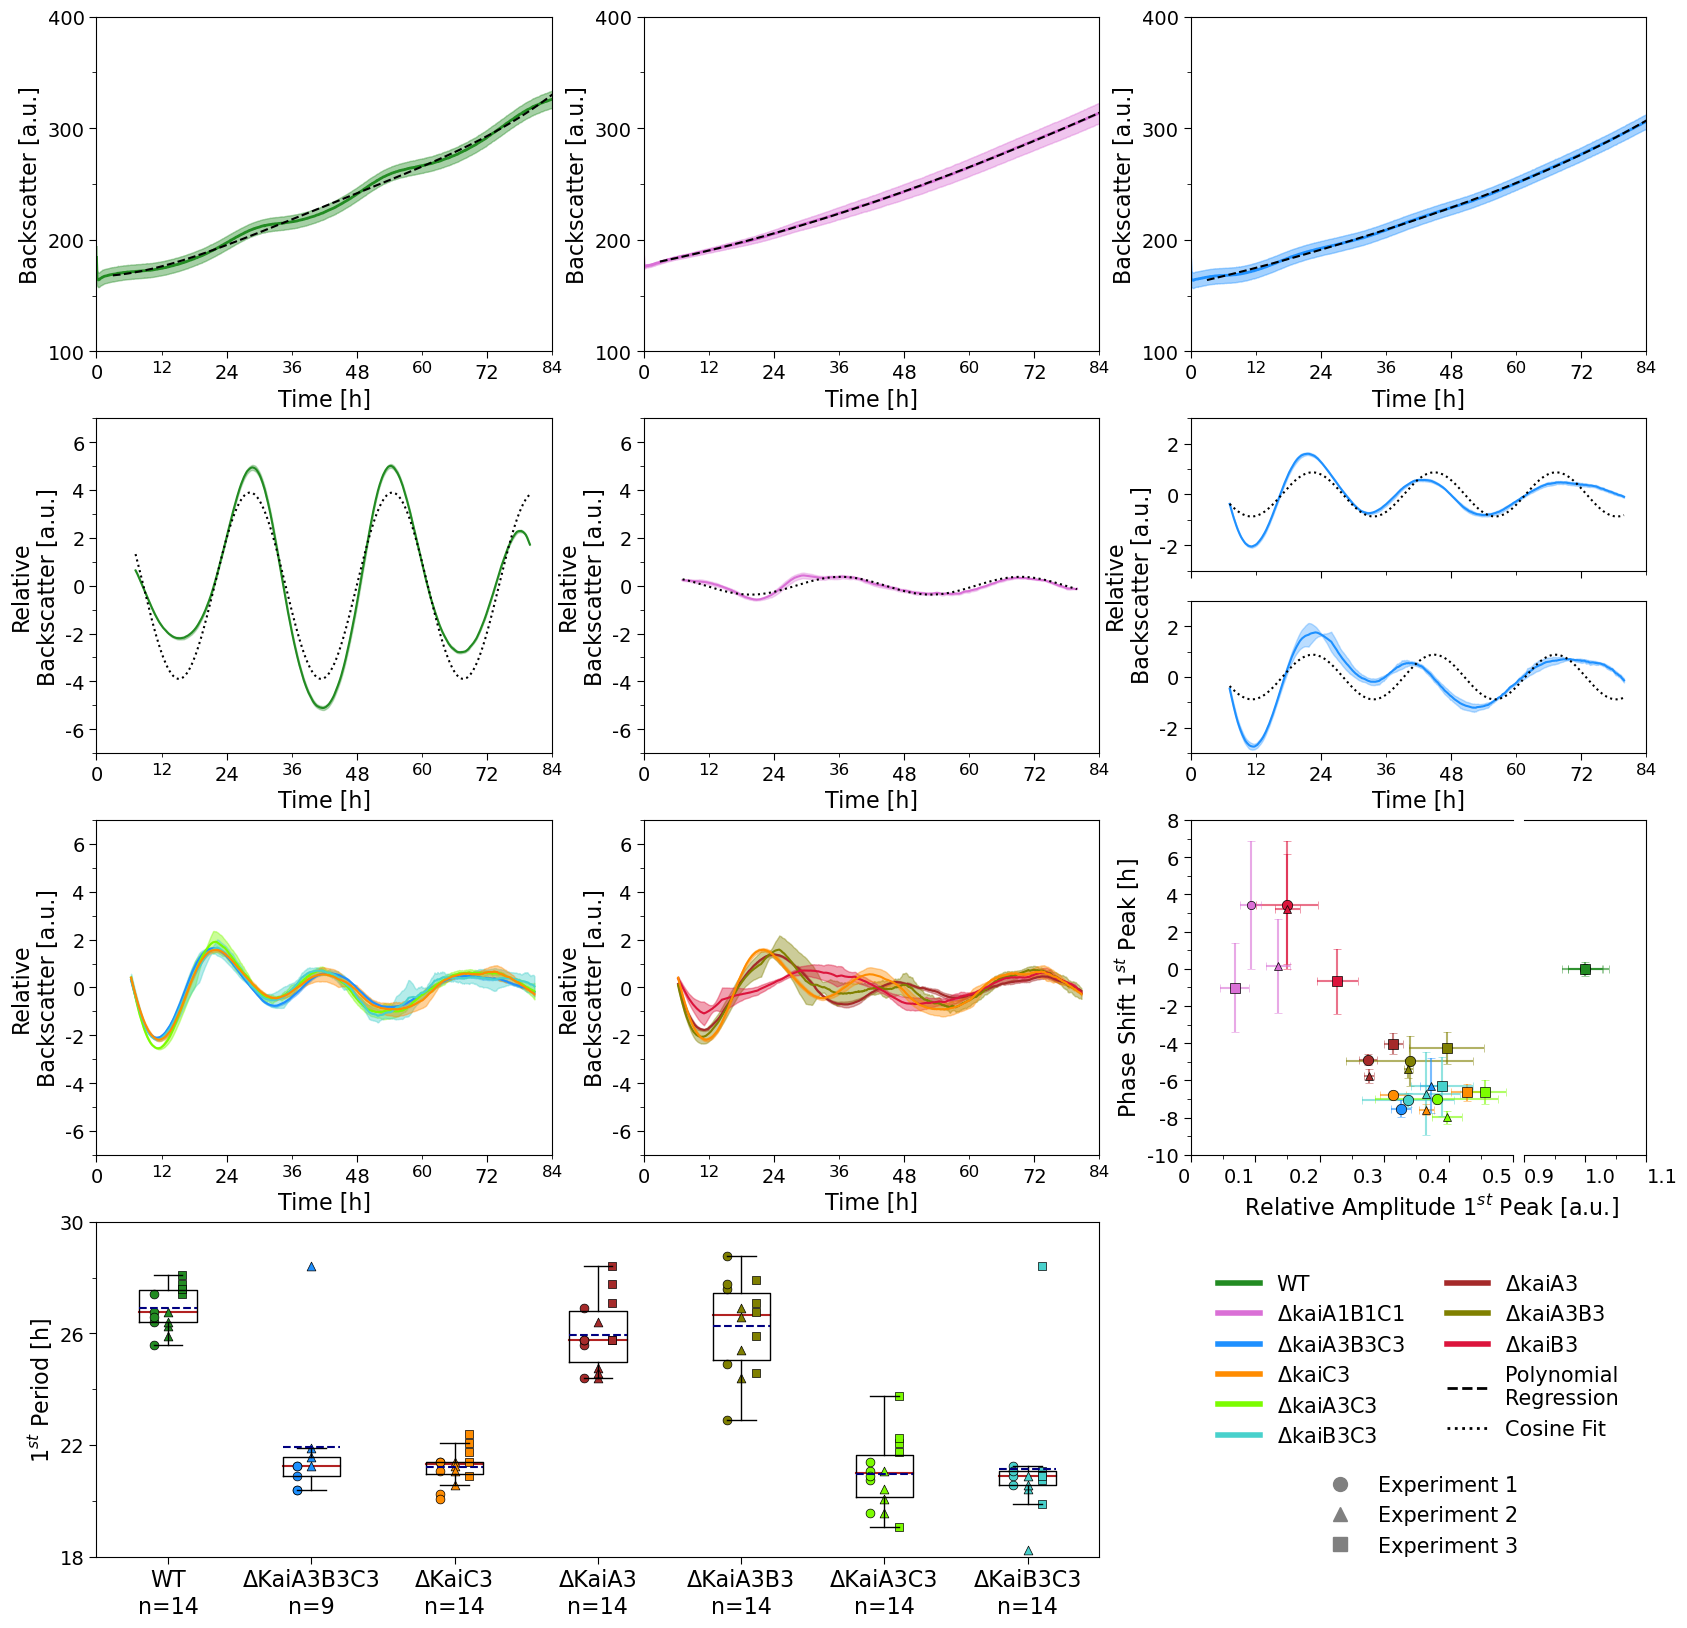

In [24]:
multiplot_4x3(color_dic=color_dic, dimensions=(20, 20), lw=lw)

In [25]:
def fit_and_params(ax:plt.Axes, data:pd.DataFrame, data_average:pd.Series, data_sd:pd.Series,
                     color:str, name:str, y_lim:tuple, period:tuple, phi:tuple) -> None:

    def cos_func(x, A, omega, phi):
        return A*np.cos(omega*x+phi)
        

    def fit_cos(ax:plt.Axes, data:pd.DataFrame, data_average:pd.Series,
                period_l:int, period_u:int, phi_l:int, phi_u:int) -> None:

        A = (max(data_average.dropna()) - np.mean(data_average.dropna()))
        omega_l = 2*np.pi/period_l
        omega_u = 2*np.pi/period_u

        popt, pcov = curve_fit(f=cos_func, xdata=data["Time[h]"].dropna(), ydata=data_average.dropna(),
                               bounds=([0, omega_u, phi_l], [A, omega_l, phi_u]))


        ax.plot(data["Time[h]"], cos_func(data["Time[h]"], popt[0], popt[1], popt[2]), c="k", ls=":", label="fit")


        return
    
    
    period_l = period[0]
    period_u = period[1]
    
    ylim_l = y_lim[0]
    ylim_u = y_lim[1]

    phi_l = (2*np.pi)/phi[1]
    phi_u = (2*np.pi)/phi[0]
    
    ax.plot(data["Time[h]"], data_average, color=color)
    ax.fill_between(data["Time[h]"], data_average+data_sd, data_average-data_sd, color=color, alpha=0.3)

    fit_cos(ax, data, data_average, period_l, period_u, phi_l, phi_u)#

    


    ax.set_title(f"{name}", fontsize=14)

    ax.set_xlim(0, 84)

    ax.set_yticks(range(-6, 7, 2), minor=False)
    ax.set_yticks(range(-7, 8, 1), minor=True)

    ax.set_xticks(range(0, 85, 24), minor=False)
    ax.set_xticks(range(0, 85, 12), minor=True)

    ax.tick_params(axis="both", which="major", labelsize=14)


    ax.set_ylim(ylim_l, ylim_u)

    return

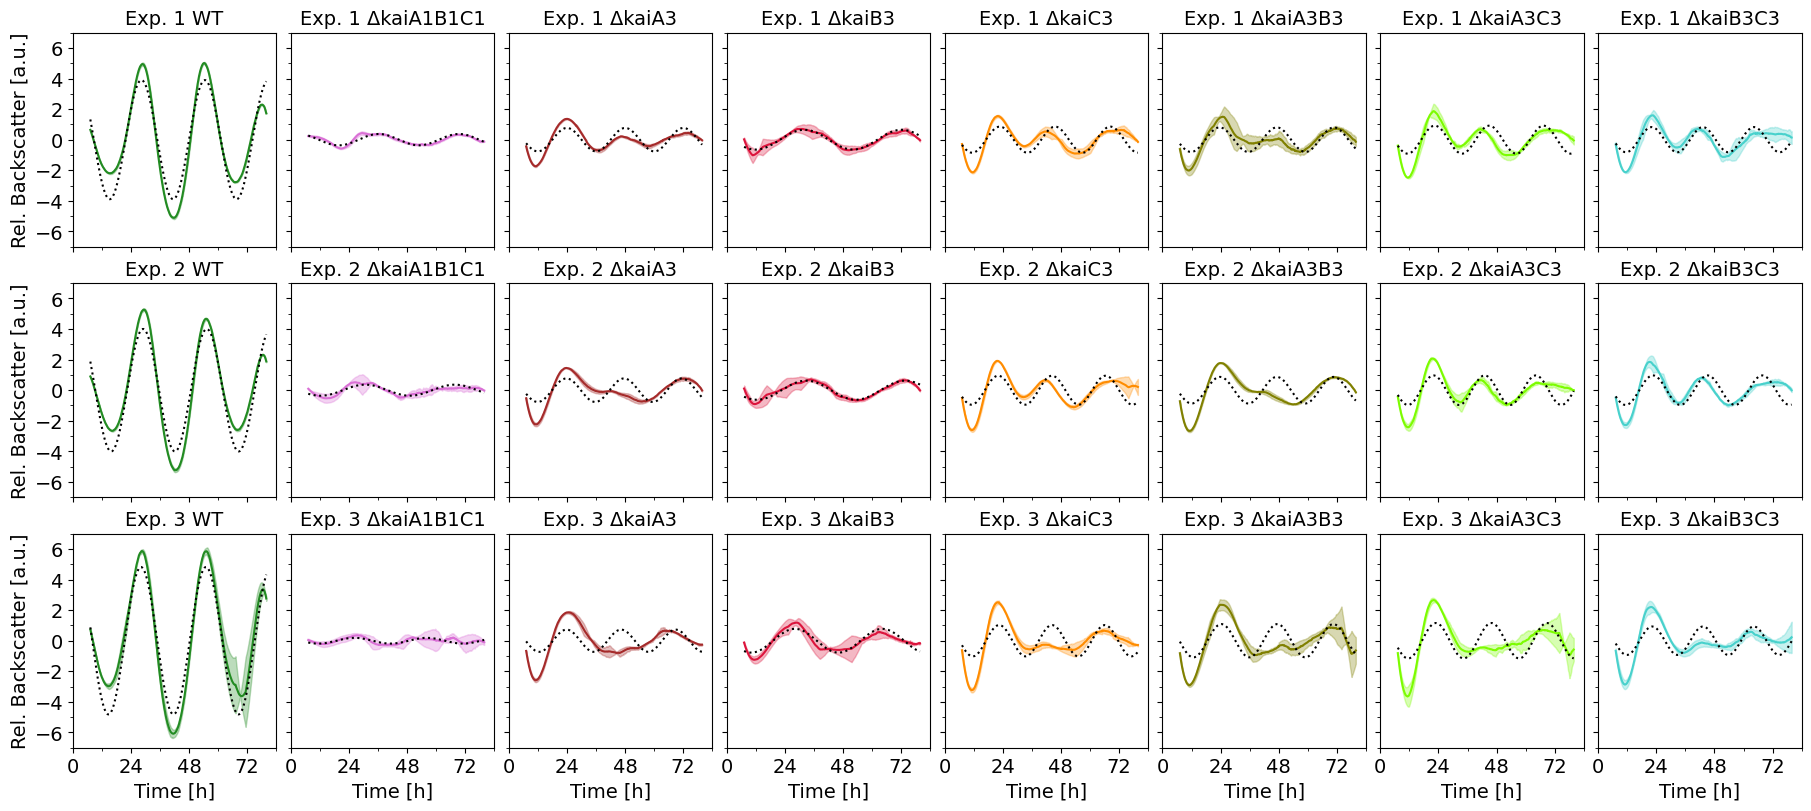

In [26]:
fig, ((ax1, ax4, ax7, ax10, ax13, ax16, ax19, ax22),
      (ax2, ax5, ax8, ax11, ax14, ax17, ax20, ax23),
      (ax3, ax6, ax9, ax12, ax15, ax18, ax21, ax24)) = plt.subplots(ncols=8, nrows=3,
                                                                    figsize=(18, 8), layout="constrained",
                                                                    sharex=True, sharey=True)


E007 = pd.read_csv("..\\data\\E007_smoothed_data.csv", index_col=0)
E008 = pd.read_csv("..\\data\\E008_smoothed_data.csv", index_col=0)
E011 = pd.read_csv("..\\data\\E011_smoothed_data.csv", index_col=0)

# WT data
E007_WT_avg, E007_WT_sd = sort_avg_sd(E007, r"WT")
E008_WT_avg, E008_WT_sd = sort_avg_sd(E008, r"WT")
E011_WT_avg, E011_WT_sd = sort_avg_sd(E011, r"WT")

# A1B1C1 data
E007_A1B1C1_avg, E007_A1B1C1_sd = sort_avg_sd(E007, r"KaiA1B1C1")
E008_A1B1C1_avg, E008_A1B1C1_sd = sort_avg_sd(E008, r"KaiA1B1C1")
E011_A1B1C1_avg, E011_A1B1C1_sd = sort_avg_sd(E011, r"KaiA1B1C1")

# A3 data
E007_A3_avg, E007_A3_sd = sort_avg_sd(E007, r"KaiA3_")
E008_A3_avg, E008_A3_sd = sort_avg_sd(E008, r"KaiA3_")
E011_A3_avg, E011_A3_sd = sort_avg_sd(E011, r"KaiA3_")

# B3 data
E007_B3_avg, E007_B3_sd = sort_avg_sd(E007, r"KaiB3_")
E008_B3_avg, E008_B3_sd = sort_avg_sd(E008, r"KaiB3_")
E011_B3_avg, E011_B3_sd = sort_avg_sd(E011, r"KaiB3_")

# C3 data
E007_C3_avg, E007_C3_sd = sort_avg_sd(E007, r"KaiC3")
E008_C3_avg, E008_C3_sd = sort_avg_sd(E008, r"KaiC3")
E011_C3_avg, E011_C3_sd = sort_avg_sd(E011, r"KaiC3")

# A3B3 data
E007_A3B3_avg, E007_A3B3_sd = sort_avg_sd(E007, r"KaiA3B3_")
E008_A3B3_avg, E008_A3B3_sd = sort_avg_sd(E008, r"KaiA3B3_")
E011_A3B3_avg, E011_A3B3_sd = sort_avg_sd(E011, r"KaiA3B3_")

# A3C3 data
E007_A3C3_avg, E007_A3C3_sd = sort_avg_sd(E007, r"KaiA3C3")
E008_A3C3_avg, E008_A3C3_sd = sort_avg_sd(E008, r"KaiA3C3")
E011_A3C3_avg, E011_A3C3_sd = sort_avg_sd(E011, r"KaiA3C3")

# B3C3 data
E007_B3C3_avg, E007_B3C3_sd = sort_avg_sd(E007, r"KaiB3C3_")
E008_B3C3_avg, E008_B3C3_sd = sort_avg_sd(E008, r"KaiB3C3_")
E011_B3C3_avg, E011_B3C3_sd = sort_avg_sd(E011, r"KaiB3C3_")

# WT fits 
fit_and_params(ax1, E007, E007_WT_avg, E007_WT_sd, "forestgreen", "Exp. 1 WT",
               (-7, 7), (18, 30), (1, 12))
fit_and_params(ax2, E008, E008_WT_avg, E008_WT_sd, "forestgreen", "Exp. 2 WT",
               (-7, 7), (18, 30), (1, 12))
fit_and_params(ax3, E011, E011_WT_avg, E011_WT_sd, "forestgreen", "Exp. 3 WT",
               (-7, 7), (18, 30), (1, 12))

# A1B1C1 fits
fit_and_params(ax4, E007, E007_A1B1C1_avg, E007_A1B1C1_sd, "orchid", "Exp. 1 \u0394kaiA1B1C1",
               (-7, 7), (28, 40), (1, 12))

fit_and_params(ax5, E008, E008_A1B1C1_avg, E008_A1B1C1_sd, "orchid", "Exp. 2 \u0394kaiA1B1C1",
               (-7, 7), (28, 40), (1, 12))
fit_and_params(ax6, E011, E011_A1B1C1_avg, E011_A1B1C1_sd, "orchid", "Exp. 3 \u0394kaiA1B1C1",
               (-7, 7), (28, 40), (1, 12))

# A3 fits
fit_and_params(ax7, E007, E007_A3_avg, E007_A3_sd, "brown", "Exp. 1 \u0394kaiA3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax8, E008, E008_A3_avg, E008_A3_sd, "brown", "Exp. 2 \u0394kaiA3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax9, E011, E011_A3_avg, E011_A3_sd, "brown", "Exp. 3 \u0394kaiA3",
               (-7, 7), (18, 26), (1, 12))

# B3 fits
fit_and_params(ax10, E007, E007_B3_avg, E007_B3_sd, "crimson", "Exp. 1 \u0394kaiB3",
               (-7, 7), (35, 50), (1, 12))
fit_and_params(ax11, E008, E008_B3_avg, E008_B3_sd, "crimson", "Exp. 2 \u0394kaiB3",
               (-7, 7), (35, 50), (1, 12))
fit_and_params(ax12, E011, E011_B3_avg, E011_B3_sd, "crimson", "Exp. 3 \u0394kaiB3",
               (-7, 7), (35, 50), (1, 12))

# C3 fits
fit_and_params(ax13, E007, E007_C3_avg, E007_C3_sd, "darkorange", "Exp. 1 \u0394kaiC3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax14, E008, E008_C3_avg, E008_C3_sd, "darkorange", "Exp. 2 \u0394kaiC3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax15, E011, E011_C3_avg, E011_C3_sd, "darkorange", "Exp. 3 \u0394kaiC3",
               (-7, 7), (18, 26), (1, 12))

# A3B3 fits
fit_and_params(ax16, E007, E007_A3B3_avg, E007_A3B3_sd, "olive", "Exp. 1 \u0394kaiA3B3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax17, E008, E008_A3B3_avg, E008_A3B3_sd, "olive", "Exp. 2 \u0394kaiA3B3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax18, E011, E011_A3B3_avg, E011_A3B3_sd, "olive", "Exp. 3 \u0394kaiA3B3",
               (-7, 7), (18, 26), (1, 12))

# A3C3 fits
fit_and_params(ax19, E007, E007_A3C3_avg, E007_A3C3_sd, "lawngreen", "Exp. 1 \u0394kaiA3C3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax20, E008, E008_A3C3_avg, E008_A3C3_sd, "lawngreen", "Exp. 2 \u0394kaiA3C3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax21, E011, E011_A3C3_avg, E011_A3C3_sd, "lawngreen", "Exp. 3 \u0394kaiA3C3",
               (-7, 7), (18, 26), (1, 12))

# B3C3 fits
fit_and_params(ax22, E007, E007_B3C3_avg, E007_B3C3_sd, "mediumturquoise", "Exp. 1 \u0394kaiB3C3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax23, E008, E008_B3C3_avg, E008_B3C3_sd, "mediumturquoise", "Exp. 2 \u0394kaiB3C3",
               (-7, 7), (18, 26), (1, 12))
fit_and_params(ax24, E011, E011_B3C3_avg, E011_B3C3_sd, "mediumturquoise", "Exp. 3 \u0394kaiB3C3",
               (-7, 7), (18, 26), (1, 12))


ax1.set_ylabel("Rel. Backscatter [a.u.]", fontsize=14)
ax2.set_ylabel("Rel. Backscatter [a.u.]", fontsize=14)
ax3.set_ylabel("Rel. Backscatter [a.u.]", fontsize=14)

ax3.set_xlabel("Time [h]", fontsize=14)
ax6.set_xlabel("Time [h]", fontsize=14)
ax9.set_xlabel("Time [h]", fontsize=14)
ax12.set_xlabel("Time [h]", fontsize=14)
ax15.set_xlabel("Time [h]", fontsize=14)
ax18.set_xlabel("Time [h]", fontsize=14)
ax21.set_xlabel("Time [h]", fontsize=14)
ax24.set_xlabel("Time [h]", fontsize=14)

fig.savefig("..\\plots\\signal+fits.png", dpi=500)
fig.savefig("..\\plots\\signal+fits.pdf", dpi=500)
# fig.savefig("..\\plots\\signal+fits.tif", dpi=500)

In [27]:
def params(data:pd.DataFrame, data_average:pd.Series,
           name:str, period:tuple, phi:tuple) -> tuple[np.ndarray, float, str]:

    def cos_func(x, A, omega, phi):
        return A*np.cos(omega*x+phi)
        

    def fit_cos(data:pd.DataFrame, data_average:pd.Series,
                period_l:int, period_u:int, phi_l:int, phi_u:int) -> tuple[np.ndarray, float]:

        A = (max(data_average.dropna()) - np.mean(data_average.dropna()))
        omega_l = 2*np.pi/period_l
        omega_u = 2*np.pi/period_u

        popt, pcov = curve_fit(f=cos_func, xdata=data["Time[h]"].dropna(), ydata=data_average.dropna(),
                               bounds=([0, omega_u, phi_l], [A, omega_l, phi_u]))

        calc_period = 1/popt[1]*2*np.pi

        return popt, calc_period
    
    
    period_l = period[0]
    period_u = period[1]

    phi_l = (2*np.pi)/phi[1]
    phi_u = (2*np.pi)/phi[0]

    popt, calc_period = fit_cos(data, data_average, period_l, period_u, phi_l, phi_u)

    return popt, calc_period, name

In [28]:
params_df = pd.DataFrame(index=["amplitude", "angular frequency", "phase angle", "period", "mean_period", "sd_period"])

# WT params
popt, calc_period, name = params(E007, E007_WT_avg, "Exp. 1 WT", (18, 30), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
popt, calc_period, name = params(E008, E008_WT_avg, "Exp. 2 WT", (18, 30), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
popt, calc_period, name = params(E011, E011_WT_avg, "Exp. 3 WT", (18, 30), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
params_df.iloc[4, 1] = np.mean(params_df.iloc[3, 0:3])
params_df.iloc[5, 1] = np.std(params_df.iloc[3, 0:3], ddof=1)

# A1B1C1 params
popt, calc_period, name = params(E007, E007_A1B1C1_avg, "Exp. 1 \u0394kaiA1B1C1", (28, 40), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
popt, calc_period, name = params(E008, E008_A1B1C1_avg, "Exp. 2 \u0394kaiA1B1C1", (28, 40), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
popt, calc_period, name = params(E011, E011_A1B1C1_avg, "Exp. 3 \u0394kaiA1B1C1", (28, 40), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
params_df.iloc[4, 4] = np.mean(params_df.iloc[3, 3:6])
params_df.iloc[5, 4] = np.std(params_df.iloc[3, 3:6], ddof=1)

# B3 fits
popt, calc_period, name = params(E007, E007_B3_avg, "Exp. 1 \u0394kaiB3", (35, 50), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
popt, calc_period, name = params(E008, E008_B3_avg, "Exp. 2 \u0394kaiB3", (35, 50), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
popt, calc_period, name = params(E011, E011_B3_avg, "Exp. 3 \u0394kaiB3", (35, 50), (1, 12))
params_df[name] = [*popt, calc_period, np.nan, np.nan]
params_df.iloc[4, 7] = np.mean(params_df.iloc[3, 6:9])
params_df.iloc[5, 7] = np.std(params_df.iloc[3, 6:9], ddof=1)

params_df.to_csv("..\\data\\fit_params.csv")
params_df

,Exp. 1 WT,Exp. 2 WT,Exp. 3 WT,Exp. 1 ΔkaiA1B1C1,Exp. 2 ΔkaiA1B1C1,Exp. 3 ΔkaiA1B1C1,Exp. 1 ΔkaiB3,Exp. 2 ΔkaiB3,Exp. 3 ΔkaiB3
amplitude,3.895401,4.004730,4.819946,0.371952,0.361532,0.188169,0.647812,0.624869,0.777516
angular frequency,0.239767,0.238704,0.234017,0.189598,0.169966,0.210564,0.156311,0.153881,0.174146
phase angle,5.781393,5.649218,5.986857,5.678684,1.057190,0.749468,1.266405,1.219450,1.372920
period,26.205426,26.322072,26.849265,33.139507,36.967209,29.839806,40.196708,40.831401,36.080018
mean_period,NaN,26.458921,NaN,NaN,33.315507,NaN,NaN,39.036042,NaN
sd_period,NaN,0.343042,NaN,NaN,3.566959,NaN,NaN,2.579587,NaN


Text(0, 0.5, 'Period [h]')

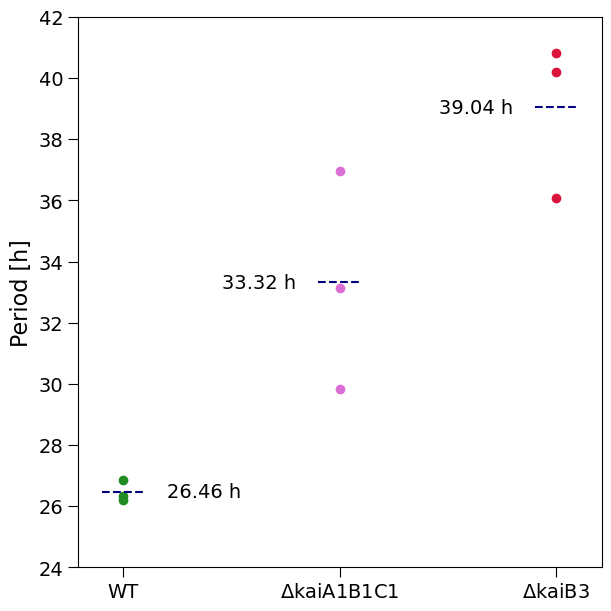

In [29]:
params_df = pd.read_csv("..\\data\\fit_params.csv", index_col=0)

fig, ax = plt.subplots(figsize=(6, 6), layout="constrained")

ax.scatter(np.repeat(1, 3), params_df.iloc[3, 0:3], color="forestgreen")
ax.hlines(np.mean(params_df.iloc[3, 0:3]), 0.9, 1.1, color="navy", ls="--")
ax.text(1.2, np.mean(params_df.iloc[3, 0:3]), f"{np.mean(params_df.iloc[3, 0:3]):.2f} h", ha="left", va="center", fontsize=14)
ax.scatter(np.repeat(2, 3), params_df.iloc[3, 3:6], color="orchid")
ax.hlines(np.mean(params_df.iloc[3, 3:6]), 1.9, 2.1, color="navy", ls="--")
ax.text(1.8, np.mean(params_df.iloc[3, 3:6]), f"{np.mean(params_df.iloc[3, 3:6]):.2f} h", ha="right", va="center", fontsize=14)
ax.scatter(np.repeat(3, 3), params_df.iloc[3, 6:9], color="crimson")
ax.hlines(np.mean(params_df.iloc[3, 6:9]), 2.9, 3.1, color="navy", ls="--")
ax.text(2.8, np.mean(params_df.iloc[3, 6:9]), f"{np.mean(params_df.iloc[3, 6:9]):.2f} h", ha="right", va="center", fontsize=14)

ax.set_xticks([1, 2, 3])
ax.set_xticklabels(["WT", "$\Delta$kaiA1B1C1", "$\Delta$kaiB3"])

ax.set_yticks(range(24, 43, 2))

ax.tick_params(axis="both", which="major", length=7, labelsize=14)
ax.set_ylabel("Period [h]", fontsize=16)


In [30]:
def fst_peak_stats() -> None:

    """ function for performing an independant two-sided t-test between all strains.
    results are saved as csv-files."""

    WT = pd.read_csv("..\\data\\WT_all_experiments_first_period.csv", index_col=0).iloc[0,:]
    A3B3C3 = pd.read_csv("..\\data\\A3B3C3_all_experiments_first_period.csv", index_col=0).iloc[0,:]
    C3 = pd.read_csv("..\\data\\KaiC3_all_experiments_first_period.csv", index_col=0).iloc[0,:]
    A3 = pd.read_csv("..\\data\\KaiA3__all_experiments_first_period.csv", index_col=0).iloc[0,:]
    A3B3 = pd.read_csv("..\\data\\KaiA3B3__all_experiments_first_period.csv", index_col=0).iloc[0,:]
    A3C3 = pd.read_csv("..\\data\\KaiA3C3_all_experiments_first_period.csv", index_col=0).iloc[0,:]
    B3C3 = pd.read_csv("..\\data\\KaiB3C3_all_experiments_first_period.csv", index_col=0).iloc[0,:]

    data_list = [WT, A3B3C3, C3, A3, A3B3, A3C3, B3C3]
    index_list = ["WT", "A3B3C3", "C3", "A3", "A3B3", "A3C3", "B3C3"]

    mean_median_df = pd.DataFrame(np.zeros((3, 7)), index=["mean", "median", "sd"], columns=index_list)

    pval_df = pd.DataFrame(np.full((7, 7), np.nan), index=index_list, columns=index_list)
    significance_df = pd.DataFrame(np.full((7, 7), False), index=index_list, columns=index_list)

    for i in range(len(data_list)):

        mean = np.mean(data_list[i])
        median = np.median(data_list[i])
        sd = np.std(data_list[i], ddof=1)

        mean_median_df.iloc[0, i] = mean
        mean_median_df.iloc[1, i] = median
        mean_median_df.iloc[2, i] = sd

        for j in range(len(data_list)):
            levene_res = levene(data_list[i], data_list[j])
            levene_pval = levene_res.pvalue

            # if both samples are the same:
            if np.array_equal(data_list[i], data_list[j]):

                pval_df.iloc[i,j] = np.nan
            else:
                # if variance differs significantly:
                if levene_pval <= 0.05:
                    # perform welch t-test
                    pval = ttest_ind(data_list[i], data_list[j], equal_var=False).pvalue
                else:
                    # otherwise performe regular t-test
                    pval = ttest_ind(data_list[i], data_list[j]).pvalue

                if pval <= 0.05:
                    pval_df.iloc[i,j] = pval
                    significance_df.iloc[i,j] = True

                else:
                    pval_df.iloc[i,j] = np.nan

    mean_median_df.to_csv("..\\data\\mean+median_boxplot.csv")
    pval_df.to_csv("..\\data\\pval_boxplot.csv")
    significance_df.to_csv("..\\data\\significance_boxplot.csv")


    fig, ax = plt.subplots(layout="constrained")
    im = ax.imshow(pval_df, cmap="summer", vmin=0, vmax=1e-3) # vmin=vmin, vmax=vmax

    ax.set_xticks(np.arange(len(index_list)), labels=index_list, rotation=30)
    ax.set_yticks(np.arange(len(index_list)), labels=index_list)

    for i in range(len(index_list)):
        for j in range(len(index_list)):
            if i == j:
                continue
            if pval_df.iloc[i, j] < 0.05:
                text = ax.text(j, i, f"{pval_df.iloc[i, j]:.1e}",
                                ha="center", va="center", color="k", fontsize=8)
            else:
                text = ax.text(j, i, f"n.s.",
                                ha="center", va="center", color="k", fontsize=8)
                
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel("pvalue", rotation=-90, va="bottom")
    ax.set_title("statistical comparison of 1st period")

    fig.savefig("..\\plots\\significance_heatmap_for_boxplot.png", dpi=500)
    fig.savefig("..\\plots\\significance_heatmap_for_boxplot.pdf", dpi=500)
    # fig.savefig("..\\plots\\significance_heatmap_for_boxplot.tif", dpi=500)

    return

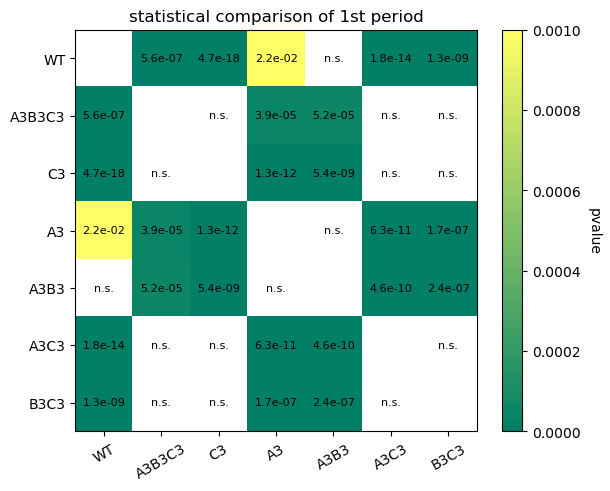

In [31]:
fst_peak_stats()

In [32]:
def plot_raw_signal_of_different_WTs(experiment:str, dimensions:tuple, lw:int) -> None:
    """
    This function plots the raw backscatter signal of two different Synechocystis sp. PCC 6803 WTs.
    """

    data = pd.read_csv(f"..\\data\\{experiment}_renamed_data.csv", index_col=0)
    data = data[sorted([key for key in data.keys() if re.search(r"Time|Wilde|WT", key)])]
    sub_data1 = data[[key for key in data.keys() if re.search(r"Wilde", key)]]
    sub_data2 = data[[key for key in data.keys() if re.search(r"WT", key)
                    and not re.search(r"Wilde", key)]]
    time = data["Time[h]"]
    fig, axs = plt.subplots(1, 2, layout="constrained", figsize=dimensions)

    xticks_major = [i for i in range(0, 85, 24)]
    xticks_minor = [i for i in range(0, 85, 12)]

    yticks_major1 = [i for i in range(0, 4501, 1000)]
    yticks_minor1 = [i for i in range(0, 4501, 500)]

    yticks_major2 = [i for i in range(150, 451, 50)]
    yticks_minor2 = [i for i in range(150, 451, 25)]

    for i in sub_data1.keys():
        name = i.removeprefix("6803_").replace("_", " ")
        y = sub_data1[i]
        axs[0].plot(time, y, label=name, lw=lw)

    for i in sub_data2.keys():
        name = "Uppsala" + i.removeprefix("6803_").replace("_", " ")
        y = sub_data2[i]
        axs[1].plot(time, y, label=name, lw=lw)

    axs[0].set_ylabel("Raw Backscatter [a.u.]", fontsize=12)
    axs[0].set_xlabel("Time [h]", fontsize=12)
    axs[0].legend(frameon=False, fontsize=9)

    axs[1].set_ylabel("Raw Backscatter [a.u.]", fontsize=12)
    axs[1].set_xlabel("Time [h]", fontsize=12)
    axs[1].legend(frameon=False, fontsize=9)

    axs[0].set_xlim(0, max(time))
    axs[0].set_xticks(xticks_major)
    axs[0].set_xticklabels(xticks_major)
    axs[0].set_xticks(xticks_minor, minor=True)
    axs[0].set_xticklabels(xticks_minor, minor=True)

    axs[1].set_xlim(0, max(time))
    axs[1].set_xticks(xticks_major)
    axs[1].set_xticklabels(xticks_major)
    axs[1].set_xticks(xticks_minor, minor=True)
    axs[1].set_xticklabels(xticks_minor, minor=True)

    axs[0].set_ylim(0, 4500)
    axs[0].set_yticks(yticks_major1)
    axs[0].set_yticklabels(yticks_major1)
    axs[0].set_yticks(yticks_minor1, minor=True)
    #axs[0].set_yticklabels(yticks_minor1, minor=True)

    axs[1].set_ylim(150, 450)
    axs[1].set_yticks(yticks_major2)
    axs[1].set_yticklabels(yticks_major2)
    axs[1].set_yticks(yticks_minor2, minor=True)
    #axs[1].set_yticklabels(yticks_minor2, minor=True)

    axs[0].tick_params(axis="both", length=5, labelsize=12)
    axs[0].tick_params(axis="x", length=3, which="minor", labelsize=9)

    axs[1].tick_params(axis="both", length=5, labelsize=12)
    axs[1].tick_params(axis="x", length=3, which="minor", labelsize=9)

    fig.savefig(f"..\\plots\\{experiment}_Wilde_vs_Uppsala.png", dpi=500)
    fig.savefig(f"..\\plots\\{experiment}_Wilde_vs_Uppsala.pdf", dpi=500)

    plt.show()

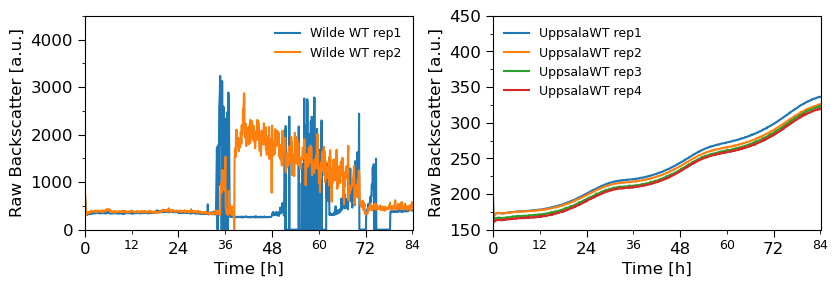

In [33]:
plot_raw_signal_of_different_WTs(experiment="E008", dimensions=(21/cm_in_inches, 7/cm_in_inches), lw=1.5)